# Statistical Analysis of Bay Area Bike Share Data

> From our initial Visual Exploratory Data Analysis on the Bay Area BIke Share dataset, we inferred that the vast majority of the trips are taken by cummuters, who are subscribers.
>
> We will also be retaining from previous analysis that we only need concern ourselves with trips no more than 60 minutes in duration
>
> Predicting ridership appears pretty easy, commuters need to commute, and customers seem to be mostly starting or ending their trips at propular tourist destinations.
>
> <b>1</b> Are Customer or Subscriber trip counts affected by Rain?
> 
> <b>2</b> Are Customer or Subscriber trip counts affected by Hot or Cold Temperatures?
>
> <b>3</b> Are Customer or Subscriber trip counts affected by Humidity Temperatures?

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from glob import glob

import seaborn as sns
# sns.set()
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 20
TICK_FONT_SIZE  = 15

In [3]:
day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

ordered_zipcodes = [94107, 95113, 94041, 94301, 94063]

# Load Data

## Trip Data

In [4]:
print('[%s] Loading Trip Data...' % datetime.datetime.now().time())

trips_df = pd.DataFrame()
trip_data_file = '../clean_data/bayareabikeshare/trip_data_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date']):
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

trips_df = pd.concat(chunks)
trips_df.user_type = trips_df.user_type.astype('category')

trips_df.drop_duplicates(inplace=True)

print('[%s] Complete!' % datetime.datetime.now().time())



[08:32:55.997695] Loading Trip Data...
		[08:32:56.642480] finished chunk 1 of 96
		[08:32:57.159518] finished chunk 10 of 96
		[08:32:57.775987] finished chunk 20 of 96
		[08:32:58.341504] finished chunk 30 of 96
		[08:32:59.011720] finished chunk 40 of 96
		[08:32:59.712549] finished chunk 50 of 96
		[08:33:00.522767] finished chunk 60 of 96
		[08:33:01.101616] finished chunk 70 of 96
		[08:33:01.700617] finished chunk 80 of 96
		[08:33:02.346735] finished chunk 90 of 96
		[08:33:02.707046] finished chunk 96 of 96
[08:33:04.697863] Complete!


In [5]:
trips = trips_df.copy()

In [6]:
trips.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,user_zip,duration_minutes
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,94114,2.900000
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,17.783333
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,18.850000


## Darksky Weather Data

In [7]:
print('[%s] Loading Weather Data...' % datetime.datetime.now().time())

weather_df = pd.DataFrame()
weather_data_file = '../clean_data/darksky/darksky_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(weather_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(weather_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['time_corrected']):
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

weather_df = pd.concat(chunks)

weather_df.drop_duplicates(inplace=True)

print('[%s] Complete!' % datetime.datetime.now().time())




[08:33:04.842537] Loading Weather Data...
		[08:33:06.174476] finished chunk 1 of 159
		[08:33:07.308045] finished chunk 16 of 159
		[08:33:08.492853] finished chunk 32 of 159
		[08:33:09.872203] finished chunk 48 of 159
		[08:33:11.127349] finished chunk 64 of 159
		[08:33:12.338211] finished chunk 80 of 159
		[08:33:13.566183] finished chunk 96 of 159
		[08:33:14.787340] finished chunk 112 of 159
		[08:33:16.183198] finished chunk 128 of 159
		[08:33:17.471138] finished chunk 144 of 159
		[08:33:18.559672] finished chunk 159 of 159
[08:33:22.488867] Complete!


In [8]:
weather = weather_df.copy()

In [9]:
weather.head(3)

,apparentTemperature,cloudCover,daily_icon,daily_summary,dewPoint,hourly_icon,hourly_summary,humidity,latitude,longitude,...,precipType,pressure,temperature,time_corrected,visibility,windBearing,windSpeed,station_id,landmark,zip_code
0,53.93,0.31,rain,"Heavy rain starting overnight, continuing unti...",50.44,partly-cloudy-night,Partly Cloudy,0.88,37.795392,-122.394203,...,1,1012.43,53.93,2014-12-16 00:00:00,9.29,131.0,10.26,50,San Francisco,94107
1,54.72,NaN,rain,"Heavy rain starting overnight, continuing unti...",50.83,clear-night,Clear,0.87,37.795392,-122.394203,...,1,1012.13,54.72,2014-12-16 01:00:00,8.41,146.0,8.84,50,San Francisco,94107
2,53.94,NaN,rain,"Heavy rain starting overnight, continuing unti...",50.07,clear-night,Clear,0.87,37.795392,-122.394203,...,1,1012.32,53.94,2014-12-16 02:00:00,8.11,149.0,8.02,50,San Francisco,94107


In [10]:
trips.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,user_zip,duration_minutes
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,94114,2.900000
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,17.783333
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,18.850000


# Merge Weather Data to Trips

In [11]:
merged = trips.merge(weather, left_on=[trips.start_terminal, trips.start_date.dt.date, trips.start_date.dt.hour],
                              right_on=[weather.station_id, weather.time_corrected.dt.date, weather.time_corrected.dt.hour], how='left')

In [12]:
merged[-merged.zip_code.isin(ordered_zipcodes)]

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,precipType,pressure,temperature,time_corrected,visibility,windBearing,windSpeed,station_id,landmark,zip_code
148880,207528,1045,2014-03-09 23:48:00,Embarcadero at Sansome,60,2014-03-10 00:05:00,Civic Center BART (7th at Market),72,273,Subscriber,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
486059,672992,273,2015-03-08 23:18:00,Davis at Jackson,42,2015-03-08 23:23:00,Commercial at Montgomery,45,527,Subscriber,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
486060,672993,185,2015-03-08 23:20:00,Davis at Jackson,42,2015-03-08 23:23:00,Beale at Market,56,427,Subscriber,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
486061,672994,269,2015-03-08 23:42:00,5th at Howard,57,2015-03-08 23:46:00,Washington at Kearny,46,372,Subscriber,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
824640,1122725,390,2016-03-13 23:36:00,2nd at Townsend,61,2016-03-13 23:42:00,Embarcadero at Bryant,54,475,Subscriber,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


## Cleanup

In [13]:
merged.cloudCover.fillna(0, inplace=True)
merged.windBearing.fillna(0, inplace=True)
merged.windSpeed.fillna(0, inplace=True)

In [14]:
merged.daily_icon = merged.daily_icon.astype('category')
merged.hourly_icon = merged.hourly_icon.astype('category')
merged.landmark = merged.landmark.astype('category')

In [15]:
merged.rename(columns={'time_corrected': 'forecast_time'}, inplace=True)

In [16]:
merged.dropna(subset=['zip_code'], axis=0, inplace=True)
merged.drop(['zip_code'], axis=1, inplace=True)

merged.sort_values('trip_id', inplace=True)
merged.reset_index(inplace=True, drop=True)

In [17]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982008 entries, 0 to 982007
Data columns (total 33 columns):
trip_id                982008 non-null int64
duration               982008 non-null int64
start_date             982008 non-null datetime64[ns]
start_station_name     982008 non-null object
start_terminal         982008 non-null int64
end_date               982008 non-null datetime64[ns]
end_station_name       982008 non-null object
end_terminal           982008 non-null int64
bike_id                982008 non-null int64
user_type              982008 non-null category
user_zip               982008 non-null int64
duration_minutes       982008 non-null float64
apparentTemperature    982008 non-null float64
cloudCover             982008 non-null float64
daily_icon             982008 non-null category
daily_summary          982008 non-null object
dewPoint               982008 non-null float64
hourly_icon            982008 non-null category
hourly_summary         982008 non-null ob

# Concurrent Trips

In [18]:
def plot_concurrent_trips(df, title):

    trips = df[['trip_id', 'start_date', 'end_date']].copy()

    trips_concurrent = pd.concat([pd.Series(1, trips.start_date),  # created add 1
                                  pd.Series(-1, trips.end_date)  # closed substract 1
                                 ]).resample('1Min').sum().cumsum()

    concur = trips_concurrent.to_frame()

    concur.columns = ['concurrent_trips']

    concur.fillna(0, inplace=True)

    trips_concurrent.groupby([trips_concurrent.index.dayofweek, trips_concurrent.index.hour, trips_concurrent.index.minute]).mean().plot(color='b', linestyle='-', marker='.', figsize=(24,6), label='Mean')
    trips_concurrent.groupby([trips_concurrent.index.dayofweek, trips_concurrent.index.hour, trips_concurrent.index.minute]).median().plot(color='g', linestyle='-', marker='.', label='Median')
    trips_concurrent.groupby([trips_concurrent.index.dayofweek, trips_concurrent.index.hour, trips_concurrent.index.minute]).max().plot(color='r', linestyle='-', marker='.', label='Max')

    plt.legend(loc=1)
    t1 = title + ' by Minute'
    plt.title(t1)
    plt.show()
    
    trips_concurrent.groupby([trips_concurrent.index.dayofweek, trips_concurrent.index.hour]).mean().plot(color='b', linestyle='-', marker='.', figsize=(24,6), label='Mean')
    trips_concurrent.groupby([trips_concurrent.index.dayofweek, trips_concurrent.index.hour]).median().plot(color='g', linestyle='-', marker='.', label='Median')
    trips_concurrent.groupby([trips_concurrent.index.dayofweek, trips_concurrent.index.hour]).max().plot(color='r', linestyle='-', marker='.', label='Max')

    plt.legend(loc=1)
    t2 = title + ' by Hour'
    plt.title(t2)
    plt.show()

# Split Morning and Evening Commuters

In [19]:
commuter_data = merged[(merged.user_type == 'Subscriber') & 
                          (merged.start_date.dt.dayofweek < 5) &
                          (merged.end_date.dt.dayofweek < 5) ].copy()
commuter_data.reset_index(inplace=True, drop=True)

commuter_data['DOW'] = commuter_data.start_date.dt.dayofweek

commuter_data.head(5)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,precipType,pressure,temperature,forecast_time,visibility,windBearing,windSpeed,station_id,landmark,DOW
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,0.0,1017.06,62.63,2013-08-29 09:00:00,10.0,183.0,0.7,64.0,San Francisco,3
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0,66.0,San Francisco,3
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0,66.0,San Francisco,3
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0,66.0,San Francisco,3
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0,66.0,San Francisco,3


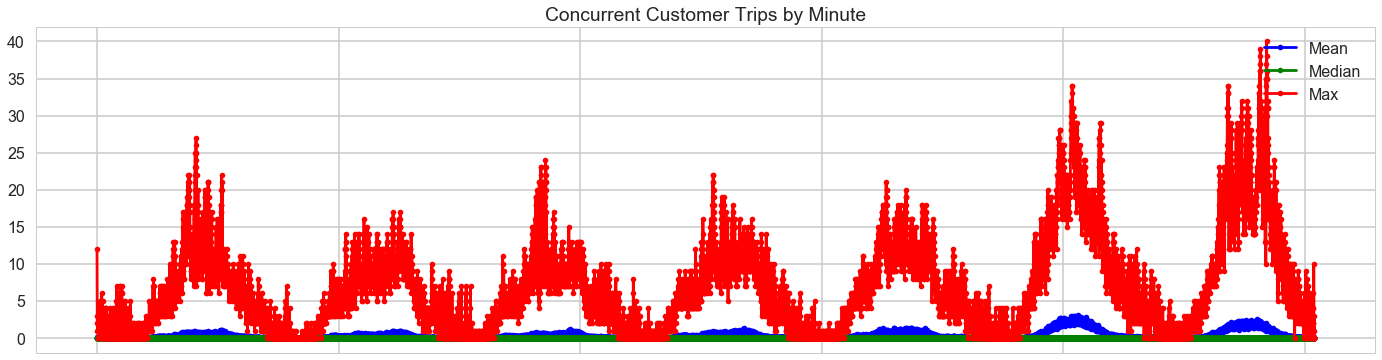

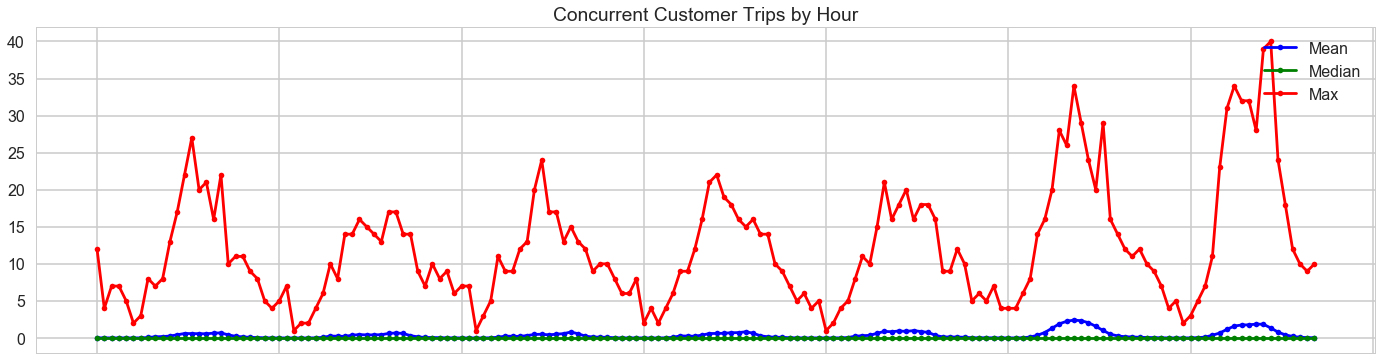

In [21]:
plot_concurrent_trips(merged[merged.user_type == 'Customer'], title='Concurrent Customer Trips')

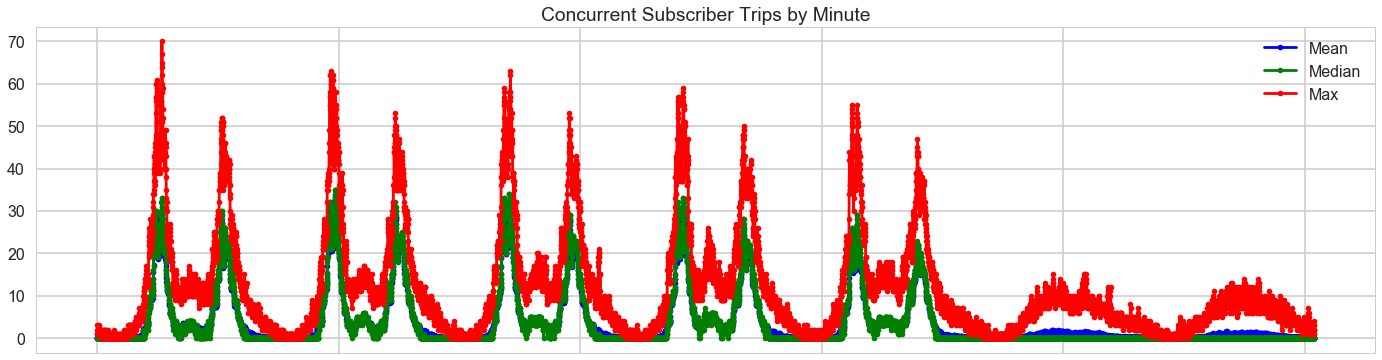

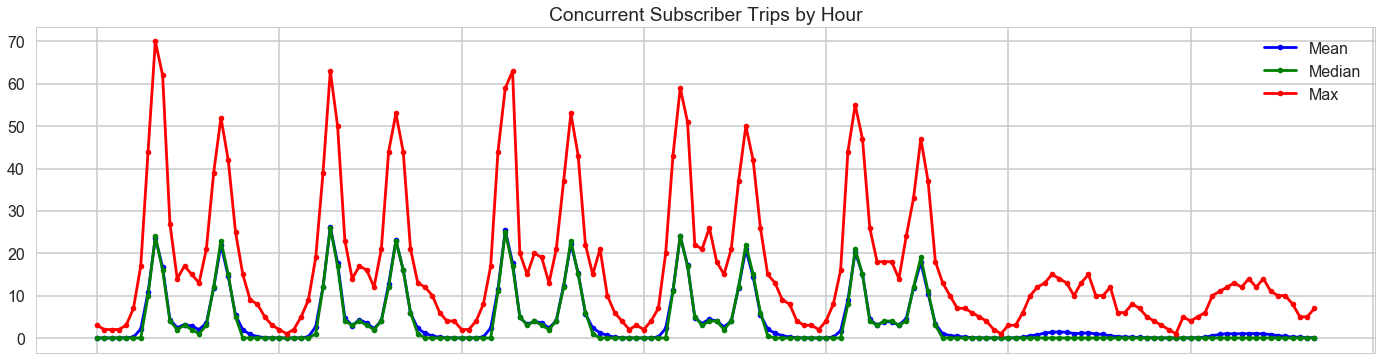

In [22]:
plot_concurrent_trips(merged[merged.user_type == 'Subscriber'], title='Concurrent Subscriber Trips')

In [23]:
morning_commute_data = commuter_data[(commuter_data.start_date.dt.hour >= 7) & 
                                (commuter_data.start_date.dt.hour < 10) & 
                                (commuter_data.end_date.dt.hour >= 7) & 
                                (commuter_data.end_date.dt.hour < 10)].copy()
morning_commute_data.reset_index(inplace=True, drop=True)
morning_commute_data.shape

(277575, 34)

In [24]:
morning_commute_data.groupby(morning_commute_data.start_date.dt.date)['trip_id'].count().mean()

353.59872611464971

In [25]:
evening_commute_data = commuter_data[(commuter_data.start_date.dt.hour >= 16) & 
                                (commuter_data.start_date.dt.hour < 19) & 
                                (commuter_data.end_date.dt.hour >= 16) & 
                                (commuter_data.end_date.dt.hour < 19)].copy()

evening_commute_data.reset_index(inplace=True, drop=True)
evening_commute_data.shape

(250199, 34)

In [26]:
evening_commute_data.groupby(evening_commute_data.start_date.dt.date)['trip_id'].count().mean()

318.72484076433119

# Yearly Ridership Trends

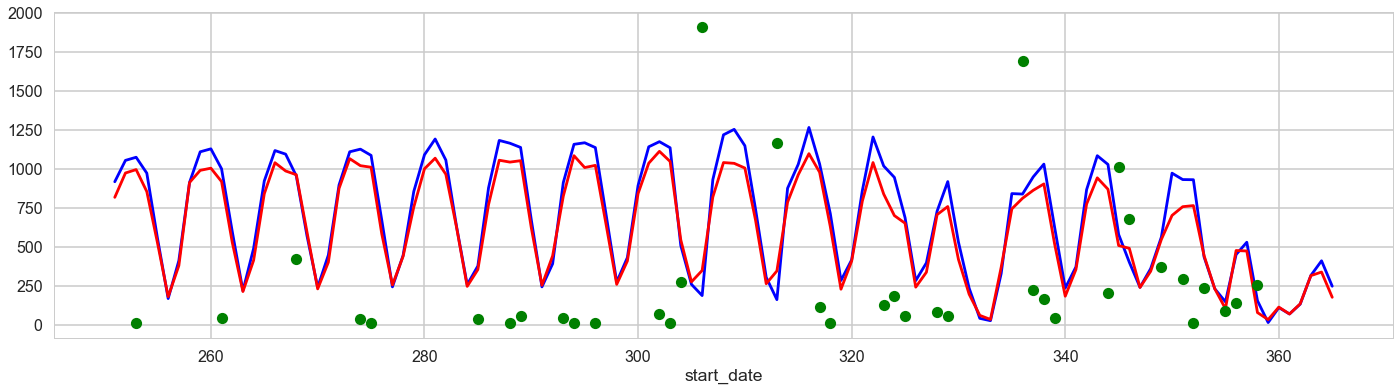

In [218]:
start_cutoff = 250
end_cutoff = start_cutoff + 200
m_df = morning_commute_data.copy()
m_df[(m_df.start_date.dt.dayofyear > start_cutoff) & (m_df.start_date.dt.dayofyear < end_cutoff)].groupby([m_df[(m_df.start_date.dt.dayofyear > start_cutoff) & (m_df.start_date.dt.dayofyear < end_cutoff)].start_date.dt.dayofyear]).count()['trip_id'].plot(color='b', figsize=(24,6))
# plt.show()

e_df = evening_commute_data.copy()
e_df[(e_df.start_date.dt.dayofyear > start_cutoff) & (e_df.start_date.dt.dayofyear < end_cutoff)].groupby([e_df[(e_df.start_date.dt.dayofyear > start_cutoff) & (e_df.start_date.dt.dayofyear < end_cutoff)].start_date.dt.dayofyear]).count()['trip_id'].plot(color='r', figsize=(24,6))


df = morning_commute_data[morning_commute_data['rain_cat'] == 'rain'].copy()
df.precipIntensity = df.precipIntensity * 20000

df[(df.start_date.dt.dayofyear > start_cutoff) & (df.start_date.dt.dayofyear < end_cutoff)].groupby([df[(df.start_date.dt.dayofyear > start_cutoff) & (df.start_date.dt.dayofyear < end_cutoff)].start_date.dt.dayofyear]).mean()['precipIntensity'].plot(linestyle='', marker='o', color='g', figsize=(24,6))
plt.show()

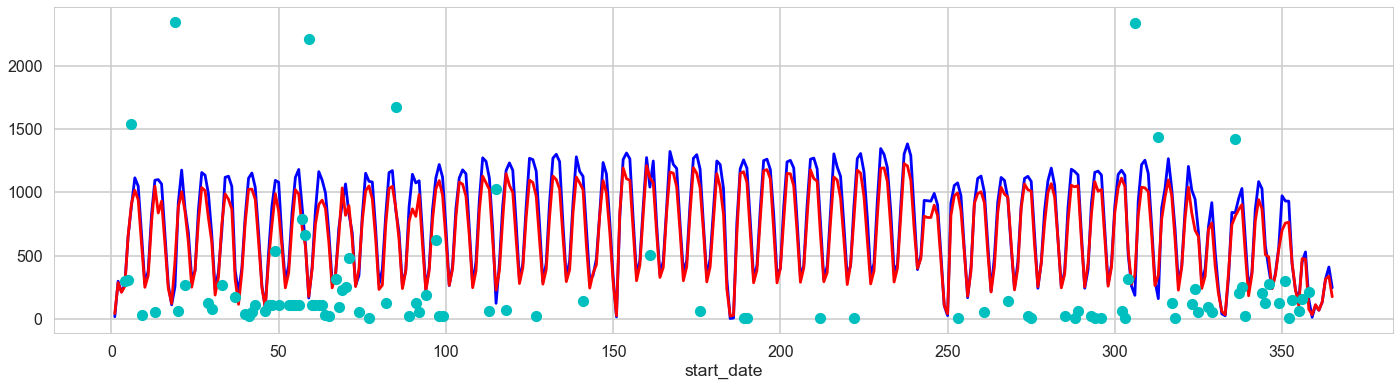

In [209]:
m_df = morning_commute_data.copy()
m_df.groupby([m_df.start_date.dt.dayofyear]).count()['trip_id'].plot(color='b', figsize=(24,6))
# plt.show()

e_df = evening_commute_data.copy()
e_df.groupby([e_df.start_date.dt.dayofyear]).count()['trip_id'].plot(color='r', figsize=(24,6))

rain_df = morning_commute_data[morning_commute_data['rain_cat'] == 'rain'].copy()
rain_df.precipIntensity = rain_df.precipIntensity * 20000

# rain_df.groupby([rain_df.start_date.dt.dayofyear]).mean()['precipIntensity'].plot(linestyle='', marker='o', color='g', figsize=(24,6))
rain_df.groupby([rain_df.start_date.dt.dayofyear]).median()['precipIntensity'].plot(linestyle='', marker='o', color='c', figsize=(24,6))
plt.show()

# Rainy and Dry Commutes

In [119]:
merged.columns

Index(['trip_id', 'duration', 'start_date', 'start_station_name',
       'start_terminal', 'end_date', 'end_station_name', 'end_terminal',
       'bike_id', 'user_type', 'user_zip', 'duration_minutes',
       'apparentTemperature', 'cloudCover', 'daily_icon', 'daily_summary',
       'dewPoint', 'hourly_icon', 'hourly_summary', 'humidity', 'latitude',
       'longitude', 'precipIntensity', 'precipProbability', 'precipType',
       'pressure', 'temperature', 'forecast_time', 'visibility', 'windBearing',
       'windSpeed', 'station_id', 'landmark'],
      dtype='object')

## Morning Commute

In [219]:
morning_commute_data['rain_cat'] = 'dry'

rain_index = morning_commute_data[(morning_commute_data.precipIntensity > 0.0) | 
                                  (morning_commute_data.precipType > 0) | 
                                  (morning_commute_data.precipProbability >= 0.59)].index


morning_commute_data.iloc[rain_index, list(morning_commute_data.columns).index('rain_cat')] = 'rain'

In [220]:
hot_cutoff  = morning_commute_data.apparentTemperature.mean() + (2 * morning_commute_data.apparentTemperature.std())
cold_cutoff = morning_commute_data.apparentTemperature.mean() - (2 * morning_commute_data.apparentTemperature.std())

morning_commute_data['temp_cat'] = 'Normal'
hot_index = morning_commute_data[morning_commute_data.apparentTemperature >= hot_cutoff].index
morning_commute_data.iloc[hot_index,list(morning_commute_data.columns).index('temp_cat')] = 'Hot'

cold_index = morning_commute_data[morning_commute_data.apparentTemperature <= cold_cutoff].index
morning_commute_data.iloc[cold_index,list(morning_commute_data.columns).index('temp_cat')] = 'Cold'


print('hot_cutoff    {:3.4f}'.format(hot_cutoff))
print('cold_cutoff   {:3.4f}'.format(cold_cutoff))
print('hot trips     {:d}'.format(hot_index.shape[0]))
print('cold trips    {:d}'.format(cold_index.shape[0]))
print('normal trips  {:d}'.format(morning_commute_data[morning_commute_data.temp_cat == 'Normal'].shape[0]))

hot_cutoff    66.7019
cold_cutoff   45.8469
hot trips     3964
cold trips    10932
normal trips  262679


## Evening Commute

In [221]:
evening_commute_data['rain_cat'] = 'dry'

rain_index = evening_commute_data[(evening_commute_data.precipIntensity > 0.0) | 
                                  (evening_commute_data.precipType > 0) | 
                                  (evening_commute_data.precipProbability >= 0.59)].index


evening_commute_data.iloc[rain_index, list(evening_commute_data.columns).index('rain_cat')] = 'rain'

In [222]:
hot_cutoff  = evening_commute_data.apparentTemperature.mean() + (2 * evening_commute_data.apparentTemperature.std())
cold_cutoff = evening_commute_data.apparentTemperature.mean() - (2 * evening_commute_data.apparentTemperature.std())

evening_commute_data['temp_cat'] = 'Normal'
hot_index = evening_commute_data[evening_commute_data.apparentTemperature >= hot_cutoff].index
evening_commute_data.iloc[hot_index,list(evening_commute_data.columns).index('temp_cat')] = 'Hot'

cold_index = evening_commute_data[evening_commute_data.apparentTemperature <= cold_cutoff].index
evening_commute_data.iloc[cold_index,list(evening_commute_data.columns).index('temp_cat')] = 'Cold'


print('hot_cutoff    {:3.4f}'.format(hot_cutoff))
print('cold_cutoff   {:3.4f}'.format(cold_cutoff))
print('hot trips     {:d}'.format(hot_index.shape[0]))
print('cold trips    {:d}'.format(cold_index.shape[0]))
print('normal trips  {:d}'.format(evening_commute_data[evening_commute_data.temp_cat == 'Normal'].shape[0]))

hot_cutoff    76.2361
cold_cutoff   50.7909
hot trips     10093
cold trips    2741
normal trips  237365


# T Test

In [223]:
from scipy.stats import ttest_ind

In [287]:
def t_test(dfA, dfB):
    
    A_mean = dfA.mean()
    B_mean = dfB.mean()
    
    diff_of_means = A_mean - B_mean
    
    # perform T test
    t, p = ttest_ind(dfA, dfB)
    
    drop_share = abs(diff_of_means / A_mean * 100.)
    
    print('A_mean        {:3.5f}'.format(A_mean))
    print('B_mean        {:3.5f}'.format(B_mean))
    print('Diff of Means {:3.5f}'.format(diff_of_means))
    print('Share Drop    {:3.5f}'.format(drop_share))
    print('   t score    {:3.5f}'.format(t))
    print('   p value    {:3.5f}'.format(p))
    
    if p <= 0.05:
        print('Reject the null Hypothesis')
    else:
        print('Can not reject the null Hypothesis')
        
#     results = {'t':t, 
#                'p':p, 
#                'A_mean':A_mean, 
#                'B_mean':B_mean, 
#                'diff_of_means':diff_of_means, 
#                'drop_share':drop_share}
    
#     results = pd.from_dict(results)
    
#     return results
    

# Impact of Rain on Commuter Trip Counts


<div class="alert alert-info">

<p><b>1a. Morning Commutes</b></p>

<p>A <b>Two Sample T Test</b> is appropriate for this problem as we are trying to see a difference between two sample means</p>
<p>Mean trip counts on rainy days vs mean trip counts on dry days</p>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Rainy Days = Morning Commuter Mean Number of trips on Dry Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Rainy Days ≠ Morning Commuter Mean Number of trips on Dry Days</li>
</ul>
</div>

<div class="alert alert-success">

<b>RESULTS</b>

</div>

In [359]:
for month in sorted(morning_commute_data.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    rainy_months = morning_commute_data[morning_commute_data.start_date.dt.month == month].copy()

    # Morning Commutes
    m_RAINY = rainy_months[rainy_months['rain_cat'] == 'rain']
    m_RAINY = m_RAINY.groupby([m_RAINY.start_date.dt.weekofyear])['trip_id'].count()

    m_DRY   = rainy_months[rainy_months['rain_cat'] == 'dry']
    m_DRY = m_DRY.groupby([m_DRY.start_date.dt.weekofyear])['trip_id'].count()
        
    t_test(m_DRY, m_RAINY)
    print('-' * 60)


Month of JAN
A_mean        3238.16667
B_mean        236.60000
Diff of Means 3001.56667
Share Drop    92.69340
   t score    3.10490
   p value    0.01262
Reject the null Hypothesis
------------------------------------------------------------

Month of FEB
A_mean        3895.60000
B_mean        226.20000
Diff of Means 3669.40000
Share Drop    94.19345
   t score    5.10907
   p value    0.00092
Reject the null Hypothesis
------------------------------------------------------------

Month of MAR
A_mean        3626.33333
B_mean        291.33333
Diff of Means 3335.00000
Share Drop    91.96617
   t score    4.16965
   p value    0.00192
Reject the null Hypothesis
------------------------------------------------------------

Month of APR
A_mean        3990.16667
B_mean        229.75000
Diff of Means 3760.41667
Share Drop    94.24210
   t score    3.47594
   p value    0.00837
Reject the null Hypothesis
------------------------------------------------------------

Month of MAY
A_mean        

/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


A_mean        4547.33333
B_mean        19.00000
Diff of Means 4528.33333
Share Drop    99.58217
   t score    nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of SEP
A_mean        4329.20000
B_mean        91.00000
Diff of Means 4238.20000
Share Drop    97.89800
   t score    6.02158
   p value    0.00095
Reject the null Hypothesis
------------------------------------------------------------

Month of OCT
A_mean        5017.00000
B_mean        62.25000
Diff of Means 4954.75000
Share Drop    98.75922
   t score    9.01440
   p value    0.00004
Reject the null Hypothesis
------------------------------------------------------------

Month of NOV
A_mean        3101.50000
B_mean        351.25000
Diff of Means 2750.25000
Share Drop    88.67483
   t score    2.25668
   p value    0.05400
Can not reject the null Hypothesis
------------------------------------------------------------

Month of DEC
A_mean        2403.6666

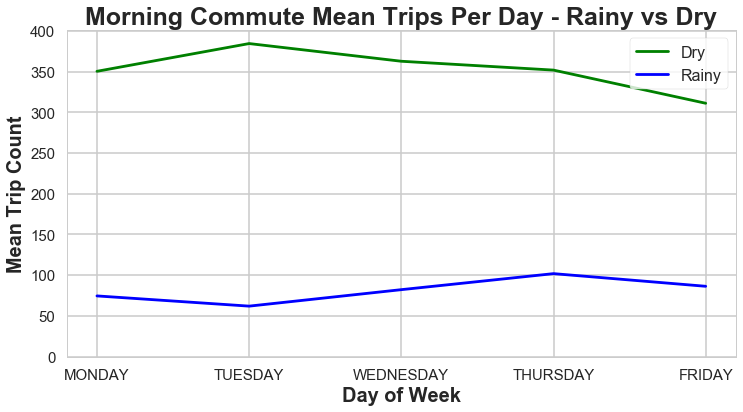

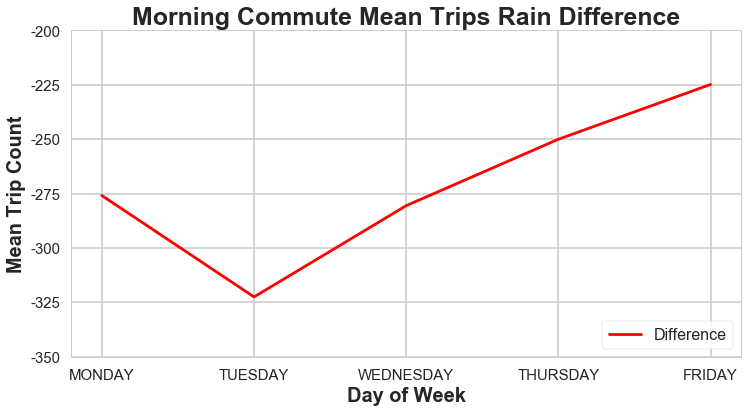

In [282]:
m_D = morning_commute_data[morning_commute_data.rain_cat == 'dry']

day_counts = list()
for d in m_D.start_date.dt.dayofweek.unique():
    day_counts.append(len(m_D[m_D.start_date.dt.dayofweek == d].start_date.dt.date.unique()))

m_D = m_D.groupby([m_D.start_date.dt.dayofweek])['trip_id'].count()
m_D = m_D / day_counts

ax = m_D.plot(color='g', label='Dry', figsize=(12,6))

m_R = morning_commute_data[morning_commute_data.rain_cat == 'rain']

day_counts = list()
for d in m_R.start_date.dt.dayofweek.unique():
    day_counts.append(len(m_R[m_R.start_date.dt.dayofweek == d].start_date.dt.date.unique()))

m_R = m_R.groupby([m_R.start_date.dt.dayofweek])['trip_id'].count()
m_R = m_R / day_counts

m_R.plot(color='b', label='Rainy', ax=ax)

ax.set_xticks(range(0,5))
ax.set_xticklabels(day_labels_full[:5], size=TICK_FONT_SIZE)

ax.set_yticks(range(0, 450, 50))
ax.set_yticklabels([str(x) for x in range(0, 450, 50)], size=TICK_FONT_SIZE)

ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Mean Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Morning Commute Mean Trips Per Day - Rainy vs Dry'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

ax.legend(loc=1, frameon=True)
plt.show()


# DIFFERENCE
diff = m_R-m_D
ax = diff.plot(color='r', label='Difference', figsize=(12,6))

ax.set_xticks(range(0,5))
ax.set_xticklabels(day_labels_full[:5], size=TICK_FONT_SIZE)

ax.set_yticks(range(-350, -175, 25))
ax.set_yticklabels([str(x) for x in range(-350, -175, 25)], size=TICK_FONT_SIZE)

ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Mean Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Morning Commute Mean Trips Rain Difference'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

ax.legend(loc=4, frameon=True)
plt.show()


<div class="alert alert-info">

<p><b>1b. Evening Commutes</b></p>

<p>A <b>Two Sample T Test</b> is appropriate for this problem as we are trying to see a difference between two sample means</p>
<p>Mean trip counts on rainy days vs mean trip counts on dry days</p>

<ul>
    <li>$H$o : Evening Commuter Mean Number of trips on Rainy Days = Evening Commuter Mean Number of trips on Dry Days</li>
    <li>$H$a : Evening Commuter Mean Number of trips on Rainy Days ≠ Evening Commuter Mean Number of trips on Dry Days</li>
</ul>
</div>

<div class="alert alert-success">
<ul> <b>Morning Commuter Stats</b>
    <li>T Statistic <b>-5.0371662439</b> </li>
    <li>P Value <b>0.0000005664</b> which is below the 0.05 threshhold thus we <b>reject</b> the $H$o</li>
    <li>The Mean Number of Evening Commute Trips on Rainy Days is about <b>52 fewer trips</b> than on Dry Days</li>
    <li>This is a <b>23.638%</b> Difference!</li>
</ul>
</div>

In [360]:
for month in sorted(evening_commute_data.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    rainy_months = evening_commute_data[evening_commute_data.start_date.dt.month == month].copy()

    # Morning Commutes
    e_RAINY = rainy_months[rainy_months['rain_cat'] == 'rain']
    e_RAINY = e_RAINY.groupby([e_RAINY.start_date.dt.weekofyear])['trip_id'].count()

    e_DRY   = rainy_months[rainy_months['rain_cat'] == 'dry']
    e_DRY = e_DRY.groupby([e_DRY.start_date.dt.weekofyear])['trip_id'].count()
        
    t_test(e_DRY, e_RAINY)
    print('-' * 60)


Month of JAN
A_mean        3063.33333
B_mean        131.25000
Diff of Means 2932.08333
Share Drop    95.71545
   t score    3.08069
   p value    0.01510
Reject the null Hypothesis
------------------------------------------------------------

Month of FEB
A_mean        3445.40000
B_mean        245.50000
Diff of Means 3199.90000
Share Drop    92.87456
   t score    5.29224
   p value    0.00113
Reject the null Hypothesis
------------------------------------------------------------

Month of MAR
A_mean        3205.50000
B_mean        384.60000
Diff of Means 2820.90000
Share Drop    88.00187
   t score    3.32805
   p value    0.00883
Reject the null Hypothesis
------------------------------------------------------------

Month of APR
A_mean        3638.50000
B_mean        170.00000
Diff of Means 3468.50000
Share Drop    95.32774
   t score    2.93380
   p value    0.02191
Reject the null Hypothesis
------------------------------------------------------------

Month of MAY
A_mean        

/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


A_mean        4016.00000
B_mean        nan
Diff of Means nan
Share Drop    nan
   t score    nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of SEP
A_mean        4045.00000
B_mean        26.00000
Diff of Means 4019.00000
Share Drop    99.35723
   t score    nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of OCT
A_mean        4673.20000
B_mean        13.00000
Diff of Means 4660.20000
Share Drop    99.72182
   t score    6.13293
   p value    0.00167
Reject the null Hypothesis
------------------------------------------------------------

Month of NOV
A_mean        2901.83333
B_mean        206.66667
Diff of Means 2695.16667
Share Drop    92.87807
   t score    2.03188
   p value    0.08169
Can not reject the null Hypothesis
------------------------------------------------------------

Month of DEC
A_mean        2087.00000
B_mean        3

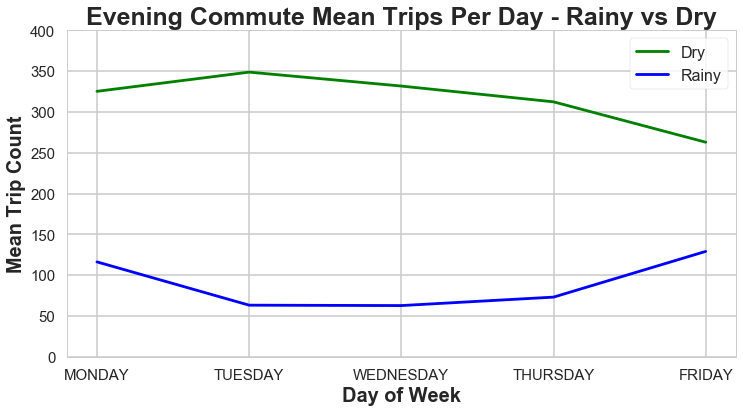

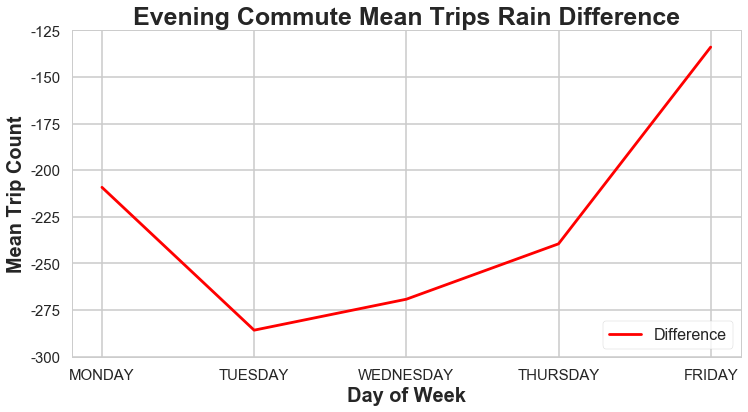

In [361]:

e_D = evening_commute_data[evening_commute_data.rain_cat == 'dry']

day_counts = list()
for d in e_D.start_date.dt.dayofweek.unique():
    day_counts.append(len(e_D[e_D.start_date.dt.dayofweek == d].start_date.dt.date.unique()))

e_D = e_D.groupby([e_D.start_date.dt.dayofweek])['trip_id'].count()
e_D = e_D / day_counts


ax = e_D.plot(color='g', label='Dry', figsize=(12,6))

e_R = evening_commute_data[evening_commute_data.rain_cat == 'rain']

day_counts = list()
for d in e_R.start_date.dt.dayofweek.unique():
    day_counts.append(len(e_R[e_R.start_date.dt.dayofweek == d].start_date.dt.date.unique()))

e_R = e_R.groupby([e_R.start_date.dt.dayofweek])['trip_id'].count()
e_R = e_R / day_counts

e_R.plot(color='b', label='Rainy', ax=ax)


ax.set_xticks(range(0,5))
ax.set_xticklabels(day_labels_full[:5], size=TICK_FONT_SIZE)

ax.set_yticks(range(0, 450, 50))
ax.set_yticklabels([str(x) for x in range(0, 450, 50)], size=TICK_FONT_SIZE)

ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Mean Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Evening Commute Mean Trips Per Day - Rainy vs Dry'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

ax.legend(loc=1, frameon=True)
plt.show()


# DIFFERENCE
diff = e_R-e_D
ax = diff.plot(color='r', label='Difference', figsize=(12,6))

ax.set_xticks(range(0,5))
ax.set_xticklabels(day_labels_full[:5], size=TICK_FONT_SIZE)

ax.set_yticks(range(-300, -100, 25))
ax.set_yticklabels([str(x) for x in range(-300, -100, 25)], size=TICK_FONT_SIZE)

ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Mean Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Evening Commute Mean Trips Rain Difference'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

ax.legend(loc=4, frameon=True)
plt.show()

# Impact of Temperature on Commuter Trip Counts


<div class="alert alert-info">

<p><b>2a. Morning Commutes</b></p>

<p>A <b>Two Sample T Test</b> is appropriate for this problem as we are trying to see a difference between two sample means</p>
<p>Mean trip counts on rainy days vs mean trip counts on dry days</p>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Cold Days = Morning Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Cold Days ≠ Morning Commuter Mean Number of trips on Normal Days</li>
</ul>
</div>

<div class="alert alert-success">
<ul> <b>Morning Commuter Stats</b>
    <li>T Statistic <b>-9.7605946790</b> </li>
    <li>P Value <b>0.0000000000</b> which is below the 0.05 threshhold thus we <b>reject</b> the $H$o</li>
    <li>The Mean Number of Morning Commute Trips on Rainy Days is about <b>58 fewer trips</b> than on Dry Days</li>
    <li>This is a <b>24.578%</b> Difference!</li>
</ul>
</div>

In [362]:
# Morning Commutes
m_COLD = morning_commute_data[morning_commute_data['temp_cat'] == 'Cold']
m_COLD = m_COLD.groupby(m_COLD.start_date.dt.date)['trip_id'].count()

m_NORM = morning_commute_data[morning_commute_data['temp_cat'] == 'Normal']
m_NORM = m_NORM.groupby(m_NORM.start_date.dt.date)['trip_id'].count()

m_HOT = morning_commute_data[morning_commute_data['temp_cat'] == 'Hot']
m_HOT = m_HOT.groupby(m_HOT.start_date.dt.date)['trip_id'].count()

In [369]:
for month in sorted(morning_commute_data.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_data = morning_commute_data[morning_commute_data.start_date.dt.month == month].copy()

    # Morning Commutes
    m_COLD = month_data[month_data['temp_cat'] == 'Cold']
    m_COLD = m_COLD.groupby([m_COLD.start_date.dt.weekofyear])['trip_id'].count()

    m_NORMAL   = month_data[month_data['temp_cat'] == 'Normal']
    m_NORMAL = m_NORMAL.groupby([m_NORMAL.start_date.dt.weekofyear])['trip_id'].count()
        
    t_test(m_NORMAL, m_COLD)
    print('-' * 60)


Month of JAN
A_mean        3769.20000
B_mean        294.33333
Diff of Means 3474.86667
Share Drop    92.19109
   t score    6.08333
   p value    0.00018
Reject the null Hypothesis
------------------------------------------------------------

Month of FEB
A_mean        3662.80000
B_mean        457.00000
Diff of Means 3205.80000
Share Drop    87.52321
   t score    3.56195
   p value    0.00738
Reject the null Hypothesis
------------------------------------------------------------

Month of MAR
A_mean        3892.66667
B_mean        30.00000
Diff of Means 3862.66667
Share Drop    99.22932
   t score    4.34052
   p value    0.00188
Reject the null Hypothesis
------------------------------------------------------------

Month of APR
A_mean        4069.66667
B_mean        53.50000
Diff of Means 4016.16667
Share Drop    98.68540
   t score    3.56915
   p value    0.00730
Reject the null Hypothesis
------------------------------------------------------------

Month of MAY
A_mean        49

/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [363]:
t_test(m_NORM, m_COLD)

A_mean        347.45899
B_mean        65.07143
Diff of Means 282.38757
Share Drop    81.27220
   t score    29.88567
   p value    0.00000
Reject the null Hypothesis


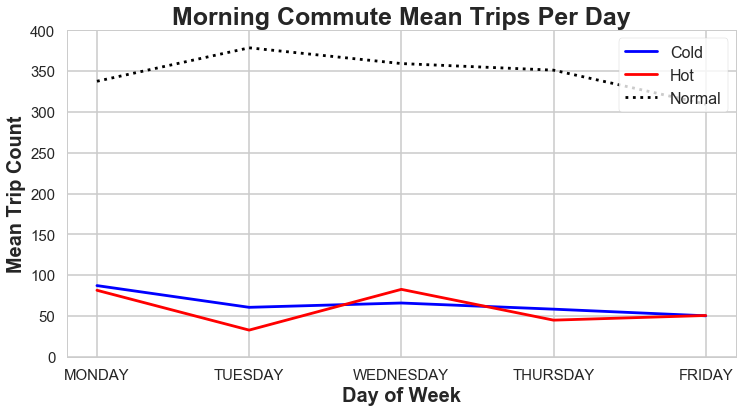

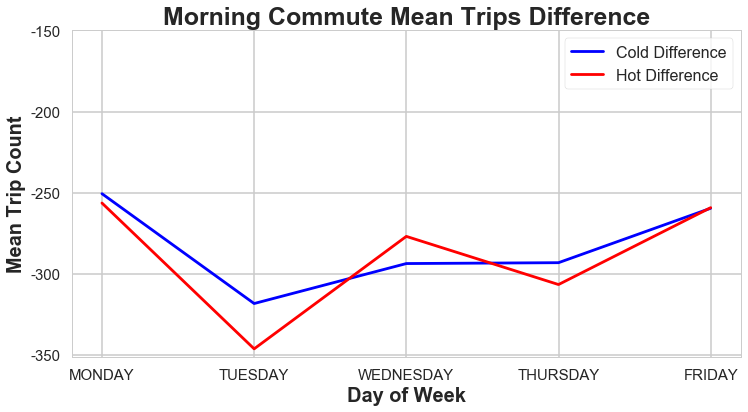

In [364]:
m_C = morning_commute_data[morning_commute_data.temp_cat == 'Cold']
day_counts = list()
for d in m_C.start_date.dt.dayofweek.unique():
    day_counts.append(len(m_C[m_C.start_date.dt.dayofweek == d].start_date.dt.date.unique()))
m_C = m_C.groupby([m_C.start_date.dt.dayofweek])['trip_id'].count()
m_C = m_C / day_counts
ax = m_C.plot(color='b', label='Cold', figsize=(12,6))


m_H = morning_commute_data[morning_commute_data.temp_cat == 'Hot']
day_counts = list()
for d in m_H.start_date.dt.dayofweek.unique():
    day_counts.append(len(m_H[m_H.start_date.dt.dayofweek == d].start_date.dt.date.unique()))
m_H = m_H.groupby([m_H.start_date.dt.dayofweek])['trip_id'].count()
m_H = m_H / day_counts
m_H.plot(color='r', label='Hot', ax=ax)



m_N = morning_commute_data[morning_commute_data.temp_cat == 'Normal']
day_counts = list()
for d in m_N.start_date.dt.dayofweek.unique():
    day_counts.append(len(m_N[m_N.start_date.dt.dayofweek == d].start_date.dt.date.unique()))
m_N = m_N.groupby([m_N.start_date.dt.dayofweek])['trip_id'].count()
m_N = m_N / day_counts
m_N.plot(linestyle=':', color='k', label='Normal', ax=ax)



ax.set_xticks(range(0,5))
ax.set_xticklabels(day_labels_full[:5], size=TICK_FONT_SIZE)

ax.set_yticks(range(0, 450, 50))
ax.set_yticklabels([str(x) for x in range(0, 450, 50)], size=TICK_FONT_SIZE)

ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Mean Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Morning Commute Mean Trips Per Day'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

ax.legend(loc=1, frameon=True)
plt.show()


# DIFFERENCE
cold_diff = m_C-m_N
hot_diff  = m_H-m_N
ax = cold_diff.plot(color='b', label='Cold Difference', figsize=(12,6))
hot_diff.plot(color='r', label='Hot Difference', ax=ax)

ax.set_xticks(range(0,5))
ax.set_xticklabels(day_labels_full[:5], size=TICK_FONT_SIZE)

ax.set_yticks(range(-350, -100, 50))
ax.set_yticklabels([str(x) for x in range(-350, -100, 50)], size=TICK_FONT_SIZE)

ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Mean Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Morning Commute Mean Trips Difference'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

ax.legend(loc=1, frameon=True)
plt.show()


<div class="alert alert-info">

<p><b>2a. Morning Commutes</b></p>

<p>A <b>Two Sample T Test</b> is appropriate for this problem as we are trying to see a difference between two sample means</p>
<p>Mean trip counts on rainy days vs mean trip counts on dry days</p>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Cold Days = Morning Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Cold Days ≠ Morning Commuter Mean Number of trips on Normal Days</li>
</ul>
</div>

<div class="alert alert-success">
<ul> <b>Morning Commuter Stats</b>
    <li>T Statistic <b>-5.0651120461</b> </li>
    <li>P Value <b>0.0000004909</b> which is below the 0.05 threshhold thus we <b>reject</b> the $H$o</li>
    <li>The Mean Number of Morning Commute Trips on Rainy Days is about <b>58 fewer trips</b> than on Dry Days</li>
    <li>This is a <b>24.578%</b> Difference!</li>
</ul>
</div>

In [365]:
t_test(m_NORM, m_HOT)

A_mean        347.45899
B_mean        57.44928
Diff of Means 290.00972
Share Drop    83.46588
   t score    20.38290
   p value    0.00000
Reject the null Hypothesis


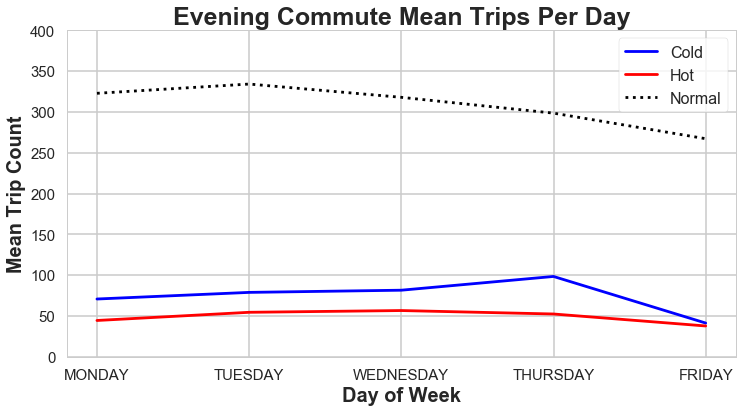

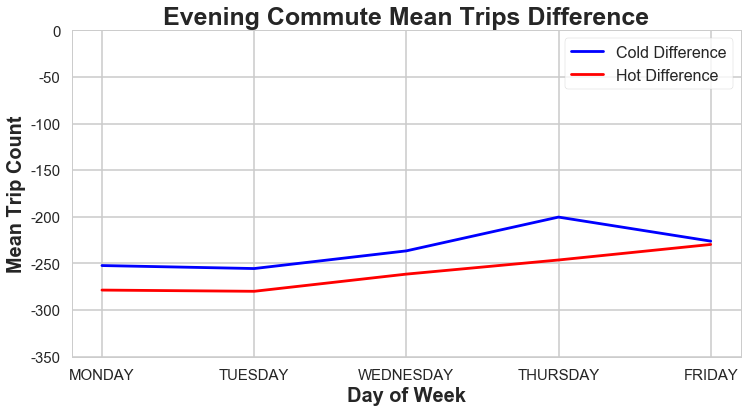

In [366]:
e_C = evening_commute_data[evening_commute_data.temp_cat == 'Cold']
day_counts = list()
for d in e_C.start_date.dt.dayofweek.unique():
    day_counts.append(len(e_C[e_C.start_date.dt.dayofweek == d].start_date.dt.date.unique()))
e_C = e_C.groupby([e_C.start_date.dt.dayofweek])['trip_id'].count()
e_C = e_C / day_counts
ax = e_C.plot(color='b', label='Cold', figsize=(12,6))


e_H = evening_commute_data[evening_commute_data.temp_cat == 'Hot']
day_counts = list()
for d in e_H.start_date.dt.dayofweek.unique():
    day_counts.append(len(e_H[e_H.start_date.dt.dayofweek == d].start_date.dt.date.unique()))
e_H = e_H.groupby([e_H.start_date.dt.dayofweek])['trip_id'].count()
e_H = e_H / day_counts
e_H.plot(color='r', label='Hot', ax=ax)


e_N = evening_commute_data[evening_commute_data.temp_cat == 'Normal']
day_counts = list()
for d in e_N.start_date.dt.dayofweek.unique():
    day_counts.append(len(e_N[e_N.start_date.dt.dayofweek == d].start_date.dt.date.unique()))
e_N = e_N.groupby([e_N.start_date.dt.dayofweek])['trip_id'].count()
e_N = e_N / day_counts
e_N.plot(linestyle=':', color='k', label='Normal', ax=ax)

ax.set_xticks(range(0,5))
ax.set_xticklabels(day_labels_full[:5], size=TICK_FONT_SIZE)

ax.set_yticks(range(0, 450, 50))
ax.set_yticklabels([str(x) for x in range(0, 450, 50)], size=TICK_FONT_SIZE)

ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Mean Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Evening Commute Mean Trips Per Day'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

ax.legend(loc=1, frameon=True)
plt.show()


# DIFFERENCE
cold_diff = e_C-e_N
hot_diff  = e_H-e_N
ax = cold_diff.plot(color='b', label='Cold Difference', figsize=(12,6))
hot_diff.plot(color='r', label='Hot Difference', ax=ax)

ax.set_xticks(range(0,5))
ax.set_xticklabels(day_labels_full[:5], size=TICK_FONT_SIZE)

ax.set_yticks(range(-350, 50, 50))
ax.set_yticklabels([str(x) for x in range(-350, 50, 50)], size=TICK_FONT_SIZE)

ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Mean Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Evening Commute Mean Trips Difference'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

ax.legend(loc=1, frameon=True)
plt.show()